In [1]:
import numpy as np
import pandas as pd
import sys
from scipy import signal
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
from ipywidgets import widgets
plt.style.use('seaborn-v0_8-notebook')
plt.rcParams.update({"axes.grid": True})

# Quarter Sin Lookup Table

https://zipcpu.com/dsp/2017/08/26/quarterwave.html

## Creating Lookup Table

In [2]:
# @markdown Choose LUT size
size = 16# @param

Generate quarter of a sin wave and save to lookup table

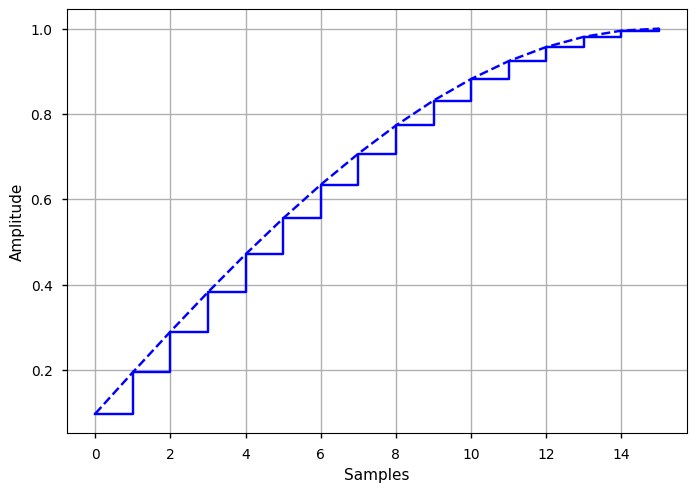

In [3]:
t = np.linspace(0, np.pi / 2, size + 1)
lut = np.sin(t)
x = np.arange(0, size, 1)

# Advance by one sample, to avoid flattening arount zero crossing
lut = np.roll(lut, -1)
lut = np.resize(lut, size)

assert(lut.size == size)

plt.plot(lut, 'b--')
plt.step(x, lut, 'b', where='post')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

Extend LUT to full sine wave

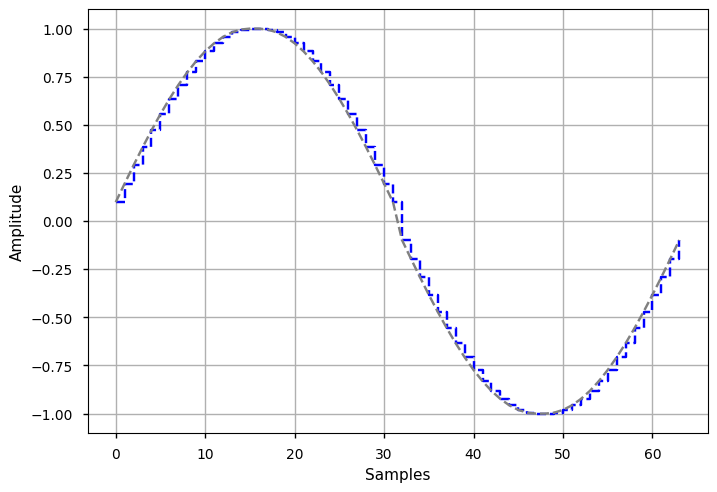

In [4]:
size_full = 4*size
lut_full = lut
lut_full = np.append(lut_full, np.flip(lut))
lut_full = np.append(lut_full, lut * -1)
lut_full = np.append(lut_full, np.flip(lut * -1))

x = np.arange(0, size_full, 1)
plt.step(x, lut_full, 'b--', where='post')
plt.plot(lut_full, '--', color='grey')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

## Controlling generated frequency

In [5]:
# @title Setup variables
sr = 48_000 # @param
f = 1 # @param
tlen = 2 # @param

Calculating period of sin in samples in $f_s$

$N_{sin} = \frac{f_s}{f_sin}$ [samples]

In [6]:
nsin = sr / f
nsin

48000.0

Calculating phase step relative to LUT size

$\Delta\Phi = \frac{N_{LUT}}{N_{sin}}$  

In [7]:
dphi = size_full / nsin
#dphi = nsin / size
dphi

0.005333333333333333

Use $\Delta\Phi$ as input for lookup

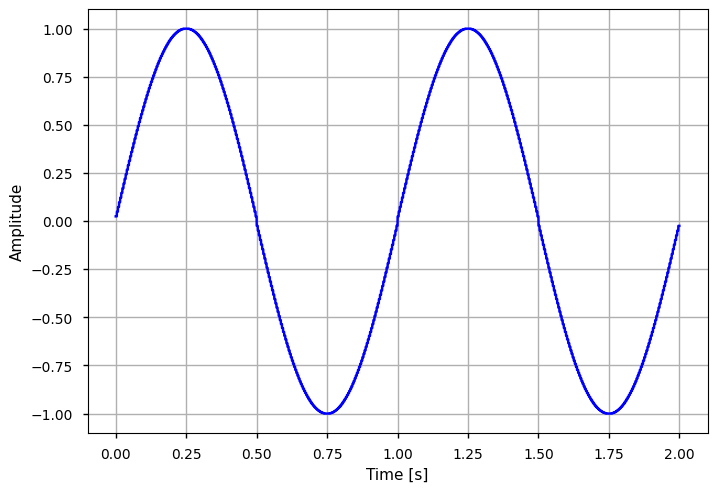

In [8]:
t = np.arange(0, tlen, 1/sr)
input = np.arange(0, t.size, 1)
input = input * dphi
input = np.mod(input, size_full)
input = np.floor(input).astype(int)

# Apply lookup
def lookup(i):
  return lut_full[i]

vlookup = np.vectorize(lookup)
y = vlookup(input)

plt.plot(t, y, '-b')
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
#plt.xlim(0, 0.5)
plt.show()

## Quarter Sin LUT Builder and Calculator

dPhi:0.5333333333333333
dPhi [quantized]:0.533203125


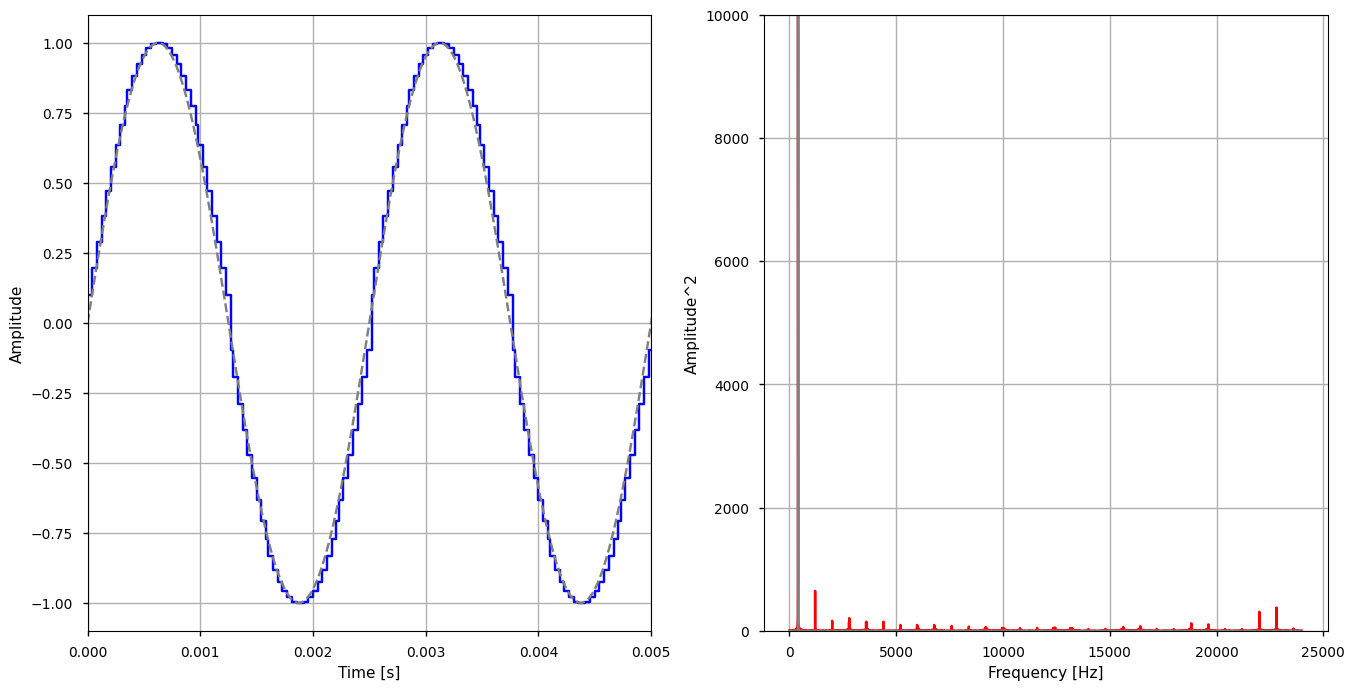

In [10]:
# @title Generate sin
# @markdown Generated signal paramenters
sr = 48_000 # @param
f = 400 # @param
tlen = 1 # @param
# @markdown ---
# @markdown Choose LUT size
size = 16 # @param
# @markdown ---
# @markdown Fixed point precision
lut_precision = 14 # @param
dphi_precision = 12 # @param
# @markdown ---

def quantize(x, precision):
  x = x * (1 << precision)
  x = np.floor(x)
  x = x / (1 << precision)
  return x

vquantize = np.vectorize(quantize)

t = np.linspace(0, np.pi / 2, size + 1)
lut = np.sin(t)
lut = np.roll(lut, -1)
lut = np.resize(lut, size)

# Quantize LUT
lut = vquantize(lut, lut_precision)


size_full = 4*size
lut_full = lut
lut_full = np.append(lut_full, np.flip(lut))
lut_full = np.append(lut_full, lut * -1)
lut_full = np.append(lut_full, np.flip(lut * -1))

nsin = sr / f
dphi = size_full / nsin

# Quantize dphi
print("dPhi:" + str(dphi))
dphi = quantize(dphi, dphi_precision)
print("dPhi [quantized]:" + str(dphi))

t = np.arange(0, tlen, 1/sr)
input = np.arange(0, t.size, 1)
input = input * dphi
input = np.mod(input, size_full)
input = np.floor(input).astype(int)

# Apply lookup
def lookup(i):
  return lut_full[i]

vlookup = np.vectorize(lookup)
y = vlookup(input)

# Spectral analysis
yfft = np.fft.fft(y)
freq = np.fft.fftfreq(yfft.size, 1/sr)

# Compare to np.sin
sin = np.sin(2 * np.pi * f * t)
sfft = np.fft.fft(sin)
sfft = np.abs(sfft)[:y.size//2]

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.step(t, y, '-b', where='post')
plt.plot(t, sin, '--', color='grey')
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.xlim(0, 1/f * 2)

plt.subplot(1, 2, 2)
logfft = np.abs(yfft)[:y.size // 2]

#with np.errstate(divide='ignore'):
#  logfft = 20 * np.log10(logfft)
plt.plot(freq[:yfft.size//2], logfft, 'r-')
plt.plot(freq[:yfft.size//2], sfft, '-', color='grey')
plt.ylim(0, 10000)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude^2")


plt.show()

### Printing LUT for VHDL

In [ ]:
import sys
def to_byte_string(x, precision):
  x = x * (1 << (precision - 2))
  x = int(np.floor(x))
  x = x.to_bytes(2, signed=True)
  return ''.join('{:02x}'.format(i) for i in x)

def to_byte_string_nop(x):
  x = int(np.floor(x))
  x = x.to_bytes(2, signed=False)
  return ''.join('{:02x}'.format(i) for i in x)

def to_vhdl_hex(x):
  return "X\"" + str(x) + "\""

vto_byte_string = np.vectorize(to_byte_string)
vto_byte_string_nop = np.vectorize(to_byte_string_nop)
vto_vhdl_hex = np.vectorize(to_vhdl_hex)

hex = vto_byte_string(lut, 16)
vhdl = vto_vhdl_hex(hex)
print(''.join('{}, '.format(i) for i in np.flip(vhdl)))

maxnum = (1 << 15) - 1
scale = np.floor(lut * maxnum)
bt = vto_byte_string_nop(scale)
vhdl = vto_vhdl_hex(bt)
print(''.join('{}, '.format(i) for i in np.flip(vhdl)))
df = pd.DataFrame([lut, scale, bt])
df.transpose()

X"4000", X"3fb1", X"3ec5", X"3d3e", X"3b20", X"3871", X"3536", X"3179", X"2d41", X"2899", X"238e", X"1e2b", X"187d", X"1294", X"0c7c", X"0645", 
X"7fff", X"7f61", X"7d89", X"7a7b", X"763f", X"70e1", X"6a6b", X"62f1", X"5a81", X"5131", X"471b", X"3c55", X"30f9", X"2527", X"18f7", X"0c89", 


,0,1,2
0,0.097961,3209.0,0c89
1,0.195068,6391.0,18f7
2,0.290283,9511.0,2527
3,0.382629,12537.0,30f9
4,0.471375,15445.0,3c55
5,0.555542,18203.0,471b
6,0.634338,20785.0,5131
7,0.707092,23169.0,5a81
8,0.77301,25329.0,62f1
9,0.831421,27243.0,6a6b


### Printing $\Delta\Phi$ values for VHDL

In [ ]:
test_frequencies = np.linspace(400, 10000, num=1000)
dphi_values = test_frequencies

def calculate_dphi(f):
  nsin = sr / f
  return size_full / nsin

def to_byte_string2(x, precision):
  x = x * (1 << (precision - 6))
  x = int(np.floor(x))
  x = x.to_bytes(4, signed=False)
  return ''.join('{:02x}'.format(i) for i in x)

vcalculate_dphi = np.vectorize(calculate_dphi)
vto_byte_string2 = np.vectorize(to_byte_string2)

dphi_values = vcalculate_dphi(dphi_values)
dphi_bytes = vto_byte_string2(dphi_values, 32)


df = pd.DataFrame([test_frequencies, dphi_values, dphi_bytes])
df = df.transpose()
df

,0,1,2
0,400.0,0.533333,02222222
1,409.60961,0.546146,022f40ef
2,419.219219,0.558959,023c5fbc
3,428.828829,0.571772,02497e8a
4,438.438438,0.584585,02569d57
...,...,...,...
995,9961.561562,13.282082,3520da20
996,9971.171171,13.294895,352df8ed
997,9980.780781,13.307708,353b17ba
998,9990.39039,13.320521,35483688


# Envelope generator

## Step by step envelope generation

In [ ]:
# @title Setup variables
sr = 48_000 # @param
tlen = 2 # @param
# @markdown ---
# @markdown Envelope parameters [ms]
a_time = 100 # @param
d_time = 100 # @param
s_time = 100 # @param
r_time = 100 # @param
# @markdown Sustain Amplitude [0 - 1]
s_amplitude = 0.5 # @param
# @markdown ---

env = ['A', 'D', 'S', 'R']
env_times = [a_time, d_time, s_time, r_time]

Calculating number of samples per envelope state

In [ ]:
def calculate_samples(time_ms):
  return sr / (1 / (time_ms / 1000))

vcalculate_samples = np.vectorize(calculate_samples)

env_samples = vcalculate_samples(env_times)
df = pd.DataFrame([env, env_times, env_samples])
df

,0,1,2,3
0,A,D,S,R
1,100,100,100,100
2,4800.0,4800.0,4800.0,4800.0


Calculating step

In [ ]:
a_step = (1.0 - 0) / env_samples[0]
d_step = (s_amplitude - 1.0) / env_samples[1]
s_step = 0.0
r_step = (0.0 - s_amplitude) / env_samples[3]
env_step = [a_step, d_step, s_step, r_step]
df.loc[len(df.index)] = env_step
df

,0,1,2,3
0,A,D,S,R
1,100,100,100,100
2,4800.0,4800.0,4800.0,4800.0
3,0.000208,-0.000104,0.0,-0.000104


Plot envelope

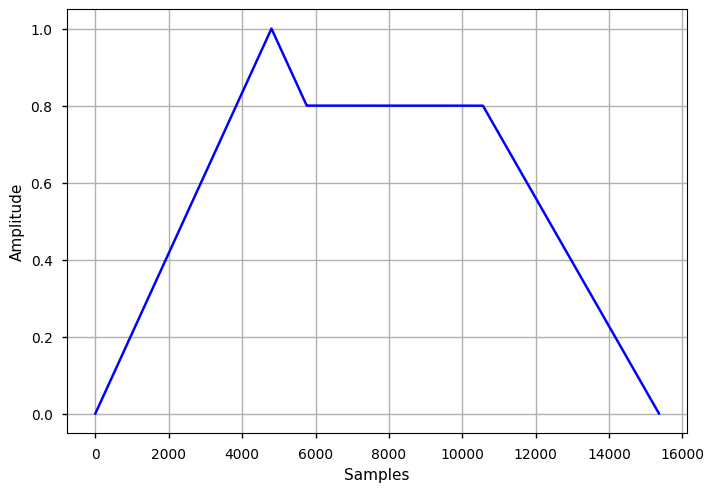

In [ ]:
def calculate_wav(start, samples, step):
  arr = np.empty(int(samples))
  arr[0] = start
  for i in range(1, int(samples)):
    arr[i] = arr[i-1] + step
  return arr

a_wav = calculate_wav(0.0, env_samples[0], env_step[0])
d_wav = calculate_wav(1.0, env_samples[1], env_step[1])
s_wav = calculate_wav(s_amplitude, env_samples[2], env_step[2])
r_wav = calculate_wav(s_amplitude, env_samples[3], env_step[3])

env_wav = np.concatenate((a_wav, d_wav, s_wav, r_wav))

plt.step(env_wav, '-b', where='post')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

## Envelope Builder and Calculator

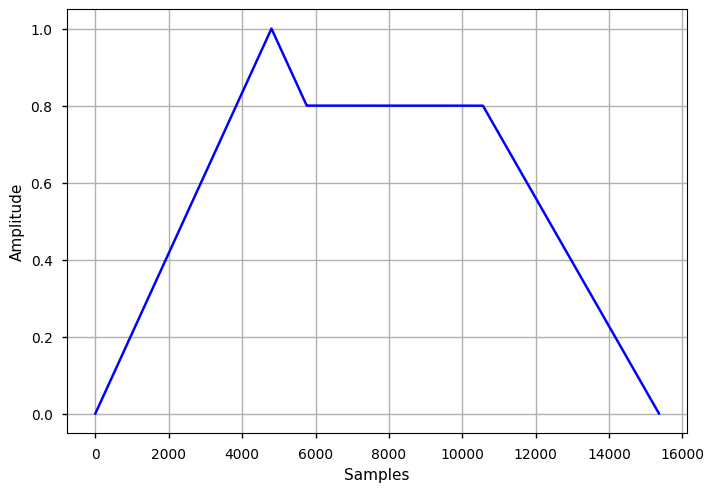

In [ ]:
# @title Create Envelope
# @markdown Sample rate [Hz]
sr = 48_000 # @param
# @markdown ---
# @markdown Envelope parameters [ms]
a_time = 100 # @param
d_time = 20 # @param
s_time = 100 # @param
r_time = 100 # @param
# @markdown Sustain Amplitude [0 - 1]
s_amplitude = 0.8 # @param
# @markdown ---

env = ['A', 'D', 'S', 'R']
env_times = [a_time, d_time, s_time, r_time]

# Calculate samples

def calculate_samples(time_ms):
  return sr / (1 / (time_ms / 1000))

vcalculate_samples = np.vectorize(calculate_samples)

env_samples = vcalculate_samples(env_times)
df = pd.DataFrame([env, env_times, env_samples])

# Calculate steps

a_step = (1.0 - 0) / env_samples[0]
d_step = (s_amplitude - 1.0) / env_samples[1]
s_step = 0.0
r_step = (0.0 - s_amplitude) / env_samples[3]
env_step = [a_step, d_step, s_step, r_step]
df.loc[len(df.index)] = env_step

# Plot envelope

def calculate_wav(start, samples, step):
  arr = np.empty(int(samples))
  arr[0] = start
  for i in range(1, int(samples)):
    arr[i] = arr[i-1] + step
  return arr

a_wav = calculate_wav(0.0, env_samples[0], env_step[0])
d_wav = calculate_wav(1.0, env_samples[1], env_step[1])
s_wav = calculate_wav(s_amplitude, env_samples[2], env_step[2])
r_wav = calculate_wav(s_amplitude, env_samples[3], env_step[3])

env_wav = np.concatenate((a_wav, d_wav, s_wav, r_wav))

plt.step(env_wav, '-b', where='post')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

### Print binary values
```
unsigned sample_count[0:15]
signed step[0:31]
```



In [ ]:
def to_byte_string_nop(x, signed):
  x = int(np.floor(x))
  x = x.to_bytes(4, signed=signed)
  return ''.join('{:02x}'.format(i) for i in x)
vto_byte_string_nop = np.vectorize(to_byte_string_nop)

env_samples_b = vto_byte_string_nop(env_samples, False)
env_scaled_step = np.array(env_step) * ((1 << 31) - 1)
env_scaled_step_b = vto_byte_string_nop(env_scaled_step, True)

print(to_byte_string_nop(s_amplitude * ((1 << 31) - 1), True))

df = pd.DataFrame(
    (env_samples, env_samples_b, env_step, env_scaled_step, env_scaled_step_b),
    ("Sample count", "Sample count hex", "Step", "Scaled step", "Scaled step hex"),
    ("A", "D", "S", "R")
  )
df


66666665


,A,D,S,R
Sample count,4800.0,960.0,4800.0,4800.0
Sample count hex,000012c0,000003c0,000012c0,000012c0
Step,0.000208,-0.000208,0.0,-0.000167
Scaled step,447392.426458,-447392.426458,0.0,-357913.941167
Scaled step hex,0006d3a0,fff92c5f,00000000,fffa89e6


In [ ]:
target = (1 << 31) - 1
sample_count = int( env_samples[0] )
step = int( env_scaled_step[0] )
print(sample_count, step)
estimate = sample_count * step
delta = target - estimate
print(target, estimate, delta)
rel_delta = delta / target
print("Error [%]", rel_delta)

4800 447392
2147483647 2147481600 2047
Error [%] 9.532086555628146e-07
